# MLP

In [1]:
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from statistics import mean
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

%load_ext tensorboard
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
%rm -rf ./logs/

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split

img = 'plots/figure_{}.png'
dataFolder = '../../data/{}'

In [2]:
def load_dataset():
    dataset = pd.read_csv(dataFolder.format('customer_behavior_labeled.csv'))
    dataset = dataset.set_index('CustomerID')
    return dataset

def standardize(dataset):
    scaler = StandardScaler()
    customers = dataset.index
    x_scaled = scaler.fit_transform(dataset)
    dataset = pd.DataFrame(x_scaled, columns=dataset.columns, index=customers)
    return dataset, scaler

def create_model(n_hidden=10, input_dim=6, lr=0.01, lr_decay=0.9, lambd=1e-5, decay_steps=500):
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=decay_steps,
        decay_rate=lr_decay)
    opt = Adam(learning_rate=lr_schedule)
    
    model = Sequential()
    model.add(Dense(n_hidden, input_dim=input_dim, activation='relu', kernel_regularizer=l2(lambd)))
    model.add(Dense(n_hidden, activation='relu', kernel_regularizer=l2(lambd)))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def get_grid_search(*args):
    import itertools
    grid = []
    for e in itertools.product(*args):
        grid.append({
            'lr': e[0],
            'lr_decay': e[1],
            'epochs': e[2],
            'batch_size': e[3],
            'lambda': e[4],
            'n_hidden': e[5]
        })
    return grid

In [3]:
dataset = load_dataset()
labels = dataset[['Customer Type']]
del dataset['Customer Type']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
print(f"Training set size = {len(X_train)}, Blind Test set size = {len(X_test)}")

Training set size = 2979, Blind Test set size = 745


In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(labels)
y_train = np.array(label_encoder.transform(y_train))
X_train, scaler = standardize(X_train)
X_train = np.array(X_train)

y_test = np.array(label_encoder.transform(y_test))
X_test = np.array(scaler.transform(X_test))

/home/gabriele/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/gabriele/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### Model Selection

In [6]:
grid_search = get_grid_search(
    [0.0001],  # lr
    [0.9],  #lr decays
    [1000],  # epochs
    [25],  # batch sizes
    [1e-7],  # lambdas
    [15]  # hidden neurons
)

In [ ]:
histories = []

with tqdm(total=len(grid_search)) as pbar:
    for g in grid_search:
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        lr = g['lr']
        lr_decay = g['lr_decay']
        epochs = g['epochs']
        batch_size = g['batch_size']
        lambd = g['lambda']
        n_hidden = g['n_hidden']

        X = X_train
        y = y_train

        input_dim = X.shape[1]
        model = create_model(n_hidden, input_dim, lr, lr_decay, lambd, 10000)

        history = model.fit(
            X,
            y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.15,
            shuffle=True,
            verbose=0,
            callbacks=[tensorboard_callback]
        )
        history.history['params'] = g
        history.history['log_name'] = log_dir
        histories.append(history)
        
        pbar.set_description(f"{g}")
        pbar.update(1)

In [ ]:
h_sorted = sorted(histories, key=lambda x: x.history['val_loss'][-1])
[f"{h.history['log_name']} | {h.history['params']} | val. accuracy={h.history['val_accuracy'][-1]} | val. loss={h.history['val_loss'][-1]}" for h in h_sorted][:10]

In [9]:
%tensorboard --logdir logs/fit --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 33867), started 1:06:39 ago. (Use '!kill 33867' to kill it.)

### Best Hyperparameters

In [18]:
lr = 0.0001
lr_decay = 0.9
epochs = 1000
batch_size = 25
lambd = 1e-7
n_hidden = 15

input_dim = X.shape[1]
decay_steps = 10000

### Model Assessment

In [19]:
model = create_model(n_hidden, input_dim, lr, lr_decay, lambd, decay_steps)

In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1)

In [ ]:
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

### Model Evaluation

In [22]:
"""json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
model.load_weights("model.h5")

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])"""
y_train_pred = np.argmax(model.predict(X_train), axis=1)

In [23]:
print("F1: {:.3f}".format(f1_score(y_train, y_train_pred, average='macro')))
print("Precision: {:.3f}".format(precision_score(y_train, y_train_pred, average='macro')))
print("Recall: {:.3f}".format(recall_score(y_train, y_train_pred, average='macro')))

F1: 0.964
Precision: 0.968
Recall: 0.961


In [24]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
y_pred = np.argmax(model.predict(X_test), axis=1)

accuracy: 97.05%


In [25]:
print("F1: {:.3f}".format(f1_score(y_test, y_pred, average='macro')))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred, average='macro')))

F1: 0.967
Precision: 0.967
Recall: 0.967


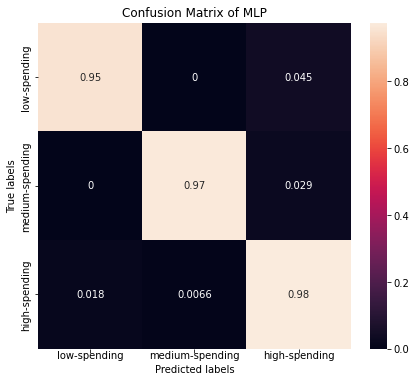

In [28]:
labels = ['medium-spending', 'low-spending', 'high-spending']
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of MLP')
ax.xaxis.set_ticklabels(['low-spending', 'medium-spending', 'high-spending'], va='center')
ax.yaxis.set_ticklabels(['low-spending', 'medium-spending', 'high-spending'], va='center')
fig = plt.gcf()
plt.savefig('plots/mlp-confusionmatrix_without_std.png')
